## Two-bus power flow

### Example review: (refer to slides: page 126)

#### Bus 0: 
- link to a generator: P_0^G = unknown, Q_0^G = unknown
- link to a load: P_0^L = 0.2 pu, Q_0^L = 0.1 pu

#### Bus 1: 
- link to a load: P_1^L = 0.5 pu, Q_1^L = 0.5 pu

#### line 0:
- admittance y = -j10 pu

Note: we can’t solve this problem directly because the power are given at one end and the voltage magnitude at the other.

[[0. 0.]
 [0. 0.]] [[-10.  10.]
 [ 10. -10.]]


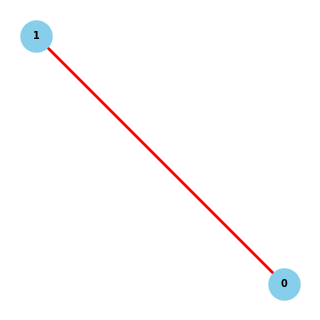

In [144]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

# read input data
buses_df = pd.DataFrame({
    'id': [0, 1],
    'P_G': [None, None], # unit: pu
    'Q_G': [None, None], # unit: pu
    'P_L': [0.2, 0.5], # unit: pu
    'Q_L': [0.1, 0.5], # unit: pu
    "admittance": -1j*10}) #unit: pu

G = nx.Graph()
# add nodes from buses
for _, row in buses_df.iterrows():
    # iterate over DataFrame rows as (index, Series) pairs
    G.add_node(row["id"], name=row['id'], carrier="AC")
    G.add_edge(0, 1, admittance = "admittance")

# plot the network
edge_colors = ["red"]
plt.figure(figsize=(3,3))
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=7, 
        font_weight='bold', edge_color=edge_colors, width=2)

def creat_ymatrix(buses):
    n = len(buses["id"])
    ymatrix = np.zeros((n,n),dtype=complex)
    admittance = buses["admittance"][0]  # unit: pu
    from_idx = 0
    to_idx = 1
    ymatrix[from_idx, to_idx] -= admittance
    ymatrix[to_idx,from_idx] -= admittance
    ymatrix[from_idx,from_idx] += admittance
    ymatrix[to_idx,to_idx] += admittance
    return ymatrix
ymatrix = creat_ymatrix(buses_df)
# apart the imaginary and real part of the Y matrix
# real part
G = np.real(ymatrix)
# imaginary part
B = np.imag(ymatrix)
print(G,B)

Then perform Newton-Raphson algorithm for power flow equations.

In [145]:
# Prepare the implicit equations using data
# classify PQ, PV, slack buses
slack = 0
PQbus = 1

# Add the attributes for each bus: P, Q, V, theta
bus_attri = {"slack": {0: {"V": 1, "theta": 0, "P": None,"Q": None}},
             "PQbus": {1: {"V": None, "theta": None, "P": -0.5,"Q": -0.5}}}

# Define equations to calculate P and Q
def p_cal(k):
    # Define power flow equations
    # param known: P, Q, G, B: dictionary containing active power P and reactive power Q of buses
    # param unknown: V, theta: dictionary containing voltages and phase angles of buses
    # param k: an integer meaning the k'th bus
    V_k = V[k]
    P_k = P[k]
    fpsum = 0
    for i in range(2):    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # susceptance: Siemens
        fpsum += V_k * V_i * (G_ki * sp.cos(theta_ki) + B_ki * sp.sin(theta_ki))
    # Unit of fpsum:  MW    
    return fpsum
def q_cal(k):
    V_k = V[k]
    Q_k = Q[k]
    fqsum = 0
    for i in range(2):    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # conductance: Siemens
        fqsum += V_k * V_i * (G_ki * sp.sin(theta_ki) - B_ki * sp.cos(theta_ki))
    # Unit of fqsum:  MVar    
    return fqsum

# Transform the function into the left side of the equation
def fp_cal(k):
    fpsum = p_cal(k)
    # Transform the function into the left side of the equation
    fpsum -= P[k]
    # Unit of fpsum:  MW    
    return fpsum
   
def fq_cal(k):
    fqsum = q_cal(k)
    fqsum -= Q[k]
    # Unit of fqsum:  MVar    
    return fqsum

Build the Jacobian matrix

In [164]:
# number of buses involved in the implicit system of equations: N
N = len(buses_df["id"])
# number of PQ buses: PQN, number of PV buses: PVN
PQN = len([PQbus])
PVN = 0
# equation number: EN
EN = 2*PQN + PVN
# P function number: PN, Q function number: QN
PN = PQN + PVN
QN = PQN
# unknown parameter V number: VN, theta number: thetaN
VN = PQN 
thetaN = PQN + PVN 
# number of rows/columns of J matrix
JN = PN + QN

# get the mapping rule of row/column-index to bus ID. Mapping can be used as subscripts.
# P
Plist = [PQbus]
sorted_Plist = enumerate(sorted(Plist))
P_mapping = {index: value for index, value in sorted_Plist}
fp_vector = [fp_result[value] for key,value in P_mapping.items()]
# Q
sorted_Qlist = enumerate(sorted([PQbus]))
Q_mapping = {index: value for index, value in sorted_Qlist}
fq_vector = [fq_result[value] for key, value in Q_mapping.items()]
# theta
theta_mapping = P_mapping
# V
V_mapping = Q_mapping

implicit_bus = [PQbus, slack]

def J_cal(PN, QN, thetaN, VN, JN, V, G, B, theta, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_bus):
    J_matrix = np.zeros((JN,JN),dtype=complex)

    #H_matrix
    H_matrix = np.zeros((PN,thetaN),dtype=complex)
    for j in range(thetaN):
        for k in range(PN):
            if theta_mapping[j] != P_mapping[k]:
                # mapping: row/column-index to bus ID
                H_matrix[k,j] = V[P_mapping[k]] * V[theta_mapping[j]] * (G[P_mapping[k], theta_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[theta_mapping[j]]) - B[P_mapping[k], theta_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    # bus ID in "implicit bus" list
                    element = 0
                    if i != P_mapping[k]:
                        element = V[P_mapping[k]] * V[i] * (-G[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]))
                    H_matrix[k,k] += element

    #M_matrix
    M_matrix = np.zeros((PN,VN),dtype=complex)
    for j in range(VN):
        for k in range(PN):
            if V_mapping[j] != P_mapping[k]:
                M_matrix[k,j] = V[P_mapping[k]] * (G[P_mapping[k], V_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != P_mapping[k]:
                        element = V[i] * (G[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]))
                    M_matrix[k,k] += element 
                M_matrix[k,k] += 2 * G[P_mapping[k],P_mapping[k]] * V[P_mapping[k]]

    #N_matrix
    N_matrix = np.zeros((QN,thetaN),dtype=complex)
    for j in range(thetaN):
        for k in range(QN):
            if theta_mapping[j] != Q_mapping[k]:
                N_matrix[k,j] = V[Q_mapping[k]] * V[theta_mapping[j]] * (-G[Q_mapping[k],theta_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[theta_mapping[j]]) - B[Q_mapping[k],theta_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != Q_mapping[k]:
                        element = V[Q_mapping[k]] * V[i] * (G[Q_mapping[k],i] * sp.cos(theta[Q_mapping[k]] - theta[i]) + B[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]] - theta[i]))
                    N_matrix[k,k] += element 

    #L_matrix
    L_matrix = np.zeros((QN,VN),dtype=complex)
    for j in range(VN):
        for k in range(QN):
            if V_mapping[j] != Q_mapping[k]:
                L_matrix[k,j] = V[Q_mapping[k]] * (G[Q_mapping[k],V_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[V_mapping[j]]) - B[Q_mapping[k],V_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != Q_mapping[k]:
                        element = V[i] * (G[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]]-theta[i]) - B[Q_mapping[k],i]* sp.cos(theta[Q_mapping[k]] - theta[i]))
                    L_matrix[k,k] += element 
                L_matrix[k,k] += -2 * B[Q_mapping[k],Q_mapping[k]] * V[Q_mapping[k]]

    #J_matrix
    top = np.hstack((H_matrix, M_matrix))  # Splice H and M left and right to calculate
    bottom = np.hstack((N_matrix, L_matrix))  # Splice N and L left and right to calculate
    J_matrix = np.vstack((top, bottom))

    return J_matrix, H_matrix, M_matrix, N_matrix, L_matrix


Iteration

In [191]:
# First Iteration
iter = 1
# Initial guess for unknown parameters: V = 1, theta = 0 
V_iter = PQbus
theta_iter = PQbus # we don't have PVbus in this example

# Extract parameters of buses
V = {slack:1,V_iter:1}
theta = {slack:0,theta_iter:0}
P = {0:None, 1: -0.5}
Q = {0:None, 1: -0.5}

fp_result = {}
fq_result = {}
i = V_iter
fp_result[i] = 999
fq_result[i] = 999
mismatches = np.array(list(fp_result.values()) + list(fq_result.values()))
mismatches = mismatches.reshape(-1, 1)
#print(mismatches.shape)


In [192]:
# Continue iterations until mismatch is small enough 
print(type(V[0]))
for iter in range(2,11):
    if all(value > 0.002 for value in mismatches):
        print(iter)
        fp_result[i] = fp_cal(i)
        fq_result[i] = fq_cal(i)
        #print("P mismatches: ",fp_result,"\n","Q mismatches:",fq_result)
        mismatches = np.array(list(fp_result.values()) + list(fq_result.values()))
        #mismatches = mismatches.reshape(-1, 1)
        #print(mismatches.shape)
        # calculate Jacobian matrix
        all_result = J_cal(PN, QN, thetaN, VN, JN, V, G, B, theta, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_bus)
        J_matrix = all_result[0]
        #print(type(J_matrix))
        try:
            inverse_J = np.linalg.inv(J_matrix)
            print("J^-1:")
            print(inverse_J.shape)
            #print(type(inverse_J))
            # update values of unknown parameters
            delta_parameters = - inverse_J @ mismatches
            #print(type(delta_parameters))
            #print(delta_parameters.shape)
            theta[i] += delta_parameters[0]
            V[i] += delta_parameters[1]
            print("theta",theta,"V",V)

        except np.linalg.LinAlgError:
            print("J is unreversible")
            break

<class 'int'>
2
J^-1:
(2, 2)
theta {0: 0, 1: -0.0500000000000000} V {0: 1, 1: 0.950000000000000}
3
J^-1:
(2, 2)
theta {0: 0, 1: -0.0528792281664029} V {0: 1, 1: 0.945757048443908}
4
J^-1:
(2, 2)
theta {0: 0, 1: -0.0528937395107719} V {0: 1, 1: 0.945732373545262}


In [193]:
print(iter,theta,V)

# calculate P for slack; Q for slack and PV bus
P[slack] = p_cal(slack)
Q[slack] = q_cal(slack)
Q[PQbus] = q_cal(PQbus)
print(P)
print(Q)

10 {0: 0, 1: -0.0528937395107719} {0: 1, 1: 0.945732373545262}
{0: 0.499999996371710, 1: -0.5}
{0: 0.555902783178063, 1: -0.499999993106380}


Calculating the lines' flows

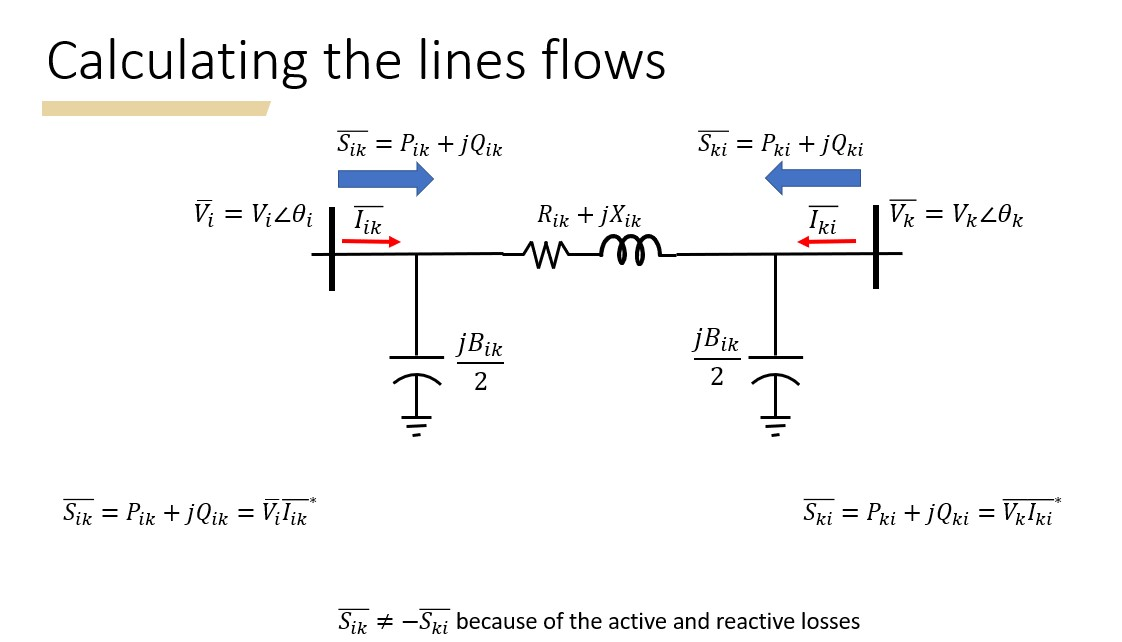

In [197]:
from IPython.display import Image
Image(filename='Data\calculating line flows.jpg')

In [194]:
def line_flow(bus):
    complex_S = np.zeros((2,2),dtype=complex)
    complex_I = np.zeros((2,2),dtype=complex)
    complex_V = np.zeros((2,1),dtype=complex)
    for i in range(2):
        complex_V[i] = V[i] * sp.cos(theta[i]) + 1j * V[i] * sp.sin(theta[i])
    for i in range(bus):
        for k in range(bus):
            if i != k:
                complex_I[i,k] = (complex_V[i] - complex_V[k]) * ymatrix[i,k] + 1j * B[i,k]/2*complex_V[i]
                complex_S[i,k] = complex_V[i] * complex_I[i,k].conjugate()
                P_flow = np.real(complex_S)
                Q_flow = np.imag(complex_S)
    return P_flow, Q_flow, complex_S, complex_I, complex_V

In [195]:
complex_S = line_flow(2)[2]
print(complex_S)

[[ 0. +0.j         -0.5-5.55590278j]
 [ 0.5-3.97204862j  0. +0.j        ]]


C:\Users\shiyu\AppData\Local\Temp\ipykernel_24948\1667978025.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  complex_I[i,k] = (complex_V[i] - complex_V[k]) * ymatrix[i,k] + 1j * B[i,k]/2*complex_V[i]
C:\Users\shiyu\AppData\Local\Temp\ipykernel_24948\1667978025.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  complex_S[i,k] = complex_V[i] * complex_I[i,k].conjugate()


$\overline{𝑆_{𝑖𝑘}}  \neq -\overline{𝑆_{ki}}$ because of the active and reactive losses.